In [59]:
#!/usr/bin/env python3
"""
Read Molpro SO-CI output for an atom in Ci computational group
Generate a diagram showing the term distribution among the lowest levels
   (as for TOC graphic)
KKI February 2024
"""
import re, sys, copy, glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fractions import Fraction

import molpro_subs as mpr
import chem_subs as chem

pd.set_option('display.width', 1000)
os.environ['OMP_NUM_THREADS'] = '1'

In [60]:
calcdir = r'C:\Users\irikura\OneDrive - NIST\Karl\atomic_SOC\calculations\Pb_I'
fname = 'pb_3PDPS1DSPDS_dac5zpp.pro'
fsoci = os.sep.join([calcdir, fname])
print(f'Will read SO-CI info from file: {fname}\nin folder {calcdir}')

Will read SO-CI info from file: pb_3PDPS1DSPDS_dac5zpp.pro
in folder C:\Users\irikura\OneDrive - NIST\Karl\atomic_SOC\calculations\Pb_I


In [61]:
atom = mpr.stoichiometry(fsoci)
charge = int(np.rint(mpr.total_charge(fsoci, verbose=True)))
print(f'The atom is {atom} with charge {charge}', end='')
# append charge
if charge > 0: 
    atom += '+'
    if charge > 1:
        atom += str(charge)
elif charge < 0:
    atom += '-'
if abs(charge) > 1:
    atom += f'{abs(charge)}'
print(f' ("{atom}")')
PG = mpr.read_compgroup(fsoci)
print(f'The computational point group is {PG}')
if PG != 'Ci':
    print('*** this script is designed for computational group Ci ***')

--- ECP replaces 60 nuclear charges ---
The atom is Pb with charge 0 ("Pb")
The computational point group is Ci


In [62]:
SOCI = mpr.fullmatSOCI(fsoci, atom=True)

Computational group = Ci
CASSCF states:
    15 Singlet
    12 Triplet
---CASSCF state 1.1 matched to MRCI state 2.1
---CASSCF state 1.1 matched to MRCI state 3.1
---CASSCF state 4.1 matched to MRCI state 5.1
---CASSCF state 4.1 matched to MRCI state 6.1
---CASSCF state 4.1 matched to MRCI state 7.1
---CASSCF state 4.1 matched to MRCI state 8.1
---CASSCF state 9.1 matched to MRCI state 10.1
---CASSCF state 9.1 matched to MRCI state 11.1
---CASSCF state 1.1 matched to MRCI state 2.1
---CASSCF state 1.1 matched to MRCI state 3.1
---CASSCF state 1.1 matched to MRCI state 4.1
---CASSCF state 1.1 matched to MRCI state 5.1
---CASSCF state 7.1 matched to MRCI state 8.1
---CASSCF state 7.1 matched to MRCI state 9.1
---CASSCF state 10.1 matched to MRCI state 11.1
---CASSCF state 10.1 matched to MRCI state 12.1
---CASSCF state 10.1 matched to MRCI state 13.1
---CASSCF state 10.1 matched to MRCI state 14.1


In [63]:
dfterm = SOCI.average_terms(be_close=['Energy', 'Edav', 'Eref', 'dipZ', 'C0'], always=True)
# drop the dipZ column
dfterm.drop(columns=['dipZ'], inplace=True)
print(f'Averaged term energies ({fname}):')
dfso = SOCI.assign_atomic_J(quiet=True)  # create SOCI.dfso
Egl = SOCI.dfso.E.min()  # energy of ground level
dfterm['Erel'] = (dfterm.Edav - Egl) * chem.AU2CM
fmt = {'ecm': '{:.1f}', 'Erel': '{:.1f}'}
display(dfterm.style.format(fmt))
print('"ecm"  is relative to the lowest term (cm-1)')
print('"Erel" is relative to the ground level')

Averaged term energies (pb_3PDPS1DSPDS_dac5zpp.pro):


C:\Users\irikura\AppData\Local\miniforge3\envs\karlwork\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Term,Edav,idx,ecm,Erel
0,(1)3P,-192.696130,[0 2 1],0.0,11176.9
1,(1)1D,-192.671100,[16 15 13 14 12],5493.3,16670.2
2,(1)1S,-192.631691,[17],14142.7,25319.6
3,(1)1P,-192.515834,[19 18 20],39570.4,50747.3
4,(1)3D,-192.512609,[3 4 7 5 6],40278.3,51455.1
5,(2)3P,-192.510669,[ 8 9 10],40703.9,51880.8
6,(1)3S,-192.507821,[11],41328.9,52505.8
7,(2)1D,-192.505775,[22 23 21 24 25],41778.0,52954.9
8,(2)1S,-192.497426,[26],43610.4,54787.3


"ecm"  is relative to the lowest term (cm-1)
"Erel" is relative to the ground level


### Distribution of terms among levels

In [64]:
if atom == 'Co':
    ecut = 20 * 1000  # upper energy limit to consider, in cm-1
    emax = 9 * 1000  # upper vertical limit for plot (cm-1)
    emin = -1000  # lower limit for plot, in cm-1
elif atom == 'Pb':
    ecut = 50 * 1000  # upper energy limit to consider, in cm-1
    emax = 30 * 1000  # upper vertical limit for plot (cm-1)
    emin = -1000  # lower limit for plot, in cm-1
else:
    print(f'*** no parameters set for atom {atom} ***')
xmax = 10  # upper limit for active x-axis
xmin = 0   # lower limit
xcent = (xmin + xmax) / 2
xterm = {2: 1, 1: 1, 0: 9}  # horizontal placement of term points for lambdas
xlvl = 3.75   # horizontal position of left end of level-bars
xmid = 0.5   # horizontal position of inner end of level-bar, relative to center
tmid = 4   # horizontal distance of term point to center
xbar = 0.75   # length of level bars
xgap = 0.2   # space between level bars and diagonal lines
barthick = 2  # for levels
thickscale = 8  # for lines connecting terms with levels

In [65]:
def tsymb(S, L):
    # return a Tex-like string for a term symbol
    smult = int(2*S + 1)
    lsymb = 'SPDFGHIKLMN'
    s = f'$^{smult}${lsymb[L]}'
    return s

Disposition of low-lying terms of Pb
*** File C:\Users\irikura\OneDrive - NIST\Karl\atomic_SOC\calculations\Pb_I\Pb_parentage_diagram_pb_3PDPS1DSPDS_dac5zpp.tif already exists***


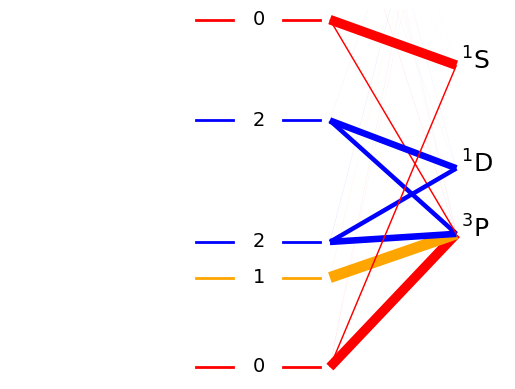

In [66]:
Elvl = SOCI.dfso[SOCI.dfso['Erel'] < ecut]['Erel'].values
Jlvl = SOCI.dfso[SOCI.dfso['Erel'] < ecut]['J'].values
# draw level bars using energies
#    each bar is in two pieces with the value of J printed in between
# set color for different J values
c = {}
toff = -0.3  # horizontal offset for J labels
eoff = 100   # downward offset for J labels
if atom == 'Co':
    c = {Fraction(5,2): 'red', Fraction(7,2): 'magenta',
         Fraction(3,2): 'blue', Fraction(1,2): 'lime', Fraction(9,2): 'orange'}
elif atom == 'PtH+':
    c.update({0.0: 'red', 1.0: 'cyan', 2.0: 'orange', 3.0: 'blue', 4.0: 'yellow'})
elif atom == 'Pb':
    c.update({0.0: 'red', 1.0: 'orange', 2.0: 'blue', 3.0: 'cyan', 4.0: 'yellow'})
    toff = -0.1
    eoff = 400

# draw the level bars and label them with J values
for i, (om, e) in enumerate(zip(Jlvl, Elvl)):
    y = [e, e]
    # left half of bar
    x = [xcent - xmid - xbar, xcent - xmid]
    plt.plot(x, y, linewidth=barthick, color=c[om])
    # right half of bar
    x = [xcent + xmid, xcent + xmid + xbar]
    plt.plot(x, y, linewidth=barthick, color=c[om])
    frac = str(Fraction(om))
    if atom == 'PtH+':
        # don't align numeral vertically because they overlap
        plt.annotate(frac, (xcent+toff+ om/7, e-eoff), fontsize=14)  # print value of J
    else:
        plt.annotate(frac, (xcent+toff, e-eoff), fontsize=14)  # print value of J

# draw lines from term energies to level energies
for iterm, trow in dfterm.iterrows():
    term = trow['Term']
    e = trow['Erel']
    #if e > emax:
    #    continue
    S, L = chem.SL_from_term(term)
    # put (singlets, doublets) on right and all else on left
    if S <= 1:
        side = +1  # right
    else:
        side = -1  # left
    tpos = xcent + tmid * side
    for jrow, lvlrow in SOCI.dfso.iterrows():
        xl = [tpos, xcent + side * (xmid + xbar + xgap)]
        yl = [e, lvlrow['Erel']]
        wid = thickscale * lvlrow['termwt'][iterm]
        plt.plot(xl, yl, linewidth=wid, color=c[Fraction(lvlrow['J'])], solid_capstyle='butt')
    # annotate with term symbol
    if side > 0:
        apos = tpos + 0.1
    else:
        apos = tpos -0.8
    plt.annotate(tsymb(S, L), (apos, e-300), fontsize=18)

plt.xlim((xmin, xmax))
plt.ylim((emin, emax))
plt.axis('off')
ftif = '{:s}_parentage_diagram_{:s}.tif'.format(atom, fname.replace('.pro', ''))
ftif = os.sep.join([calcdir, ftif])
print(f'Disposition of low-lying terms of {atom}')
if os.path.isfile(ftif):
    print(f'*** File {ftif} already exists***')
else:
    plt.savefig(ftif, dpi=300)
    print(f'Plot saved to file {ftif}')
plt.show()

In [67]:
dfterm

,Term,Edav,idx,ecm,Erel
0,(1)3P,-192.69613,"[0, 2, 1]",0.0,11176.855057
1,(1)1D,-192.6711,"[16, 15, 13, 14, 12]",5493.3,16670.183053
2,(1)1S,-192.631691,[17],14142.7,25319.55888
3,(1)1P,-192.515834,"[19, 18, 20]",39570.4,50747.296357
4,(1)3D,-192.512609,"[3, 4, 7, 5, 6]",40278.3,51455.107603
5,(2)3P,-192.510669,"[8, 9, 10]",40703.9,51880.771628
6,(1)3S,-192.507821,[11],41328.9,52505.784899
7,(2)1D,-192.505775,"[22, 23, 21, 24, 25]",41778.0,52954.86116
8,(2)1S,-192.497426,[26],43610.4,54787.27856


In [68]:
print(ftif)
SOCI.dfso

C:\Users\irikura\OneDrive - NIST\Karl\atomic_SOC\calculations\Pb_I\Pb_parentage_diagram_pb_3PDPS1DSPDS_dac5zpp.tif


,Lead,J,Jlbl,Erel,Eshift,Composition,E,Nr,termwt
0,(1)3P,0.0,(1)3P_0,0.000000,-11176.852863,"{'(1)3P': 0.86, '(1)1S': 0.13}",-192.747055,[1],"[0.8628653277805937, 3.6987777742496394e-13, 0..."
1,(1)3P,1.0,(1)3P_1,7509.540365,-3667.312497,{'(1)3P': 1.0},-192.712839,"[2, 3, 4]","[0.9971774594344612, 3.305082067188628e-12, 2...."
2,(1)3P,2.0,(1)3P_2,10495.927619,-680.925244,"{'(1)3P': 0.59, '(1)1D': 0.4}",-192.699232,"[5, 6, 7, 8, 9]","[0.59157451891727, 0.4048686839893221, 5.63024..."
3,(1)1D,2.0,(1)1D_2,20683.649567,9506.796704,"{'(1)3P': 0.41, '(1)1D': 0.59}",-192.652814,"[10, 11, 12, 13, 14]","[0.406604977654379, 0.5914640966449676, 3.7291..."
4,(1)1S,0.0,(1)1S_0,29141.625915,17964.773053,"{'(1)3P': 0.13, '(1)1S': 0.87}",-192.614276,[15],"[0.13222666348532527, 9.452573716172207e-14, 0..."
5,(1)3D,1.0,(1)3D_1,43080.235326,31903.382463,"{'(1)1P': 0.25, '(1)3D': 0.72, '(1)3S': 0.03}",-192.550767,"[16, 17, 18]","[2.7418120516074866e-07, 4.703526372895797e-13..."
6,(2)3P,0.0,(2)3P_0,44175.102304,32998.249441,"{'(2)3P': 0.75, '(2)1S': 0.24}",-192.545779,[19],"[0.0033670405911925523, 1.1508162529724674e-11..."
7,(2)3P,1.0,(2)3P_1,44358.861449,33182.008587,"{'(1)1P': 0.13, '(1)3D': 0.11, '(2)3P': 0.51, ...",-192.544941,"[20, 21, 22]","[0.0009145702666780689, 2.2686628421538126e-11..."
8,(1)3D,2.0,(1)(1)3D_2,44534.263532,33357.410669,"{'(1)3D': 0.54, '(2)3P': 0.17, '(2)1D': 0.29}",-192.544142,"[23, 24, 25, 26, 27]","[0.0002346759026535368, 0.001478741882717402, ..."
9,(1)1P,1.0,(1)1P_1,54917.386659,43740.533797,"{'(1)1P': 0.5, '(1)3D': 0.17, '(2)3P': 0.33}",-192.496833,"[28, 29, 30]","[0.0011763866184236228, 3.2382718385417075e-12..."


### Code below is to plot naive and accurate parentages together

In [69]:
# Use theoretical levels to compute naive term energies
# Assume that the assigned term is also the leading term! 
if atom == 'Pb':
    Enaive = {}
    for term in ['3P', '1D', '1S']: 
        subdf = SOCI.dfso[SOCI.dfso.Lead == '(1)' + term]
        wts = 2 * subdf.J.values + 1
        elev = subdf.Erel.values
        eavg = np.dot(wts, elev) / wts.sum()
        Enaive[term] = np.round(eavg, 0)
else:
    print(f'*** naive term energies not defined for atom {atom} ***')
chem.print_dict(Enaive)

3P :     8334.0
1D :     20684.0
1S :     29142.0


Disposition of low-lying terms of Pb
Plot saved to file C:\Users\irikura\OneDrive - NIST\Karl\atomic_SOC\calculations\Pb_I\Pb_parentage_diagram_pb_3PDPS1DSPDS_dac5zpp.tif


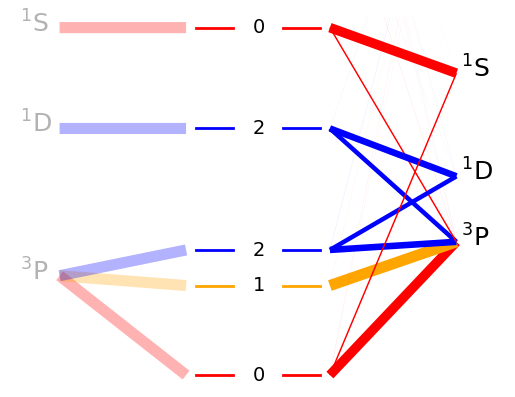

In [72]:
Elvl = SOCI.dfso[SOCI.dfso['Erel'] < ecut]['Erel'].values
Jlvl = SOCI.dfso[SOCI.dfso['Erel'] < ecut]['J'].values
# draw level bars using energies
#    each bar is in two pieces with the value of J printed in between
# set color for different J values
c = {}
toff = -0.3  # horizontal offset for J labels
eoff = 100   # downward offset for J labels
if atom == 'Co':
    c = {Fraction(5,2): 'red', Fraction(7,2): 'magenta',
         Fraction(3,2): 'blue', Fraction(1,2): 'lime', Fraction(9,2): 'orange'}
elif atom == 'PtH+':
    c.update({0.0: 'red', 1.0: 'cyan', 2.0: 'orange', 3.0: 'blue', 4.0: 'yellow'})
elif atom == 'Pb':
    c.update({0.0: 'red', 1.0: 'orange', 2.0: 'blue', 3.0: 'cyan', 4.0: 'yellow'})
    toff = -0.1
    eoff = 400

# draw the level bars and label them with J values
for i, (om, e) in enumerate(zip(Jlvl, Elvl)):
    y = [e, e]
    # left half of bar
    x = [xcent - xmid - xbar, xcent - xmid]
    plt.plot(x, y, linewidth=barthick, color=c[om])
    # right half of bar
    x = [xcent + xmid, xcent + xmid + xbar]
    plt.plot(x, y, linewidth=barthick, color=c[om])
    frac = str(Fraction(om))
    if atom == 'PtH+':
        # don't align numeral vertically because they overlap
        plt.annotate(frac, (xcent+toff+ om/7, e-eoff), fontsize=14)  # print value of J
    else:
        plt.annotate(frac, (xcent+toff, e-eoff), fontsize=14)  # print value of J

# draw lines from term energies to level energies
for iterm, trow in dfterm.iterrows():
    term = trow['Term']
    e = trow['Erel']
    #if e > emax:
    #    continue
    S, L = chem.SL_from_term(term)
    # put accurate values on the right
    side = +1
    tpos = xcent + tmid * side
    for jrow, lvlrow in SOCI.dfso.iterrows():
        xl = [tpos, xcent + side * (xmid + xbar + xgap)]
        yl = [e, lvlrow['Erel']]
        wid = thickscale * lvlrow['termwt'][iterm]
        plt.plot(xl, yl, linewidth=wid, color=c[Fraction(lvlrow['J'])], solid_capstyle='butt')
    # annotate with term symbol
    if side > 0:
        apos = tpos + 0.1
    else:
        apos = tpos -0.8
    plt.annotate(tsymb(S, L), (apos, e-300), fontsize=18)

# do the same for the naive conception
for term, e in Enaive.items():
    # put naive values on the left
    side = -1
    tpos = xcent + tmid * side
    subdf = SOCI.dfso[SOCI.dfso.Lead == '(1)' + term]
    for jrow, lvlrow in subdf.iterrows():
        xl = [tpos, xcent + side * (xmid + xbar + xgap)]
        yl = [e, lvlrow['Erel']]
        wid = thickscale * 1.0  # 100% is the naive assumption
        plt.plot(xl, yl, linewidth=wid, color=c[Fraction(lvlrow['J'])], solid_capstyle='butt', alpha=0.3)
    # annotate with term symbol
    if side > 0:
        apos = tpos + 0.1
    else:
        apos = tpos -0.8
    S, L = chem.SL_from_term(term)
    plt.annotate(tsymb(S, L), (apos, e-300), fontsize=18, alpha=0.3)

plt.xlim((xmin, xmax))
plt.ylim((emin, emax))
plt.axis('off')
ftif2 = ftif.replace('.pro', '_with_naive.pro')
print(f'Disposition of low-lying terms of {atom}')
if os.path.isfile(ftif2):
    print(f'*** File {ftif2} already exists***')
else:
    plt.savefig(ftif2, dpi=300)
    print(f'Plot saved to file {ftif2}')
plt.show()